In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from catboost import Pool

import os

Import raw data

In [2]:
trainDf = pd.read_csv('./data/train.csv',index_col='id')
trainDf.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [ ]:
de 

Train dataframe consists of 59 features.

### Feature reEnginering 

#### Here I will try to decreate dimension of feature space.

1) Drop all "calc" features

In [4]:
def dropCalcFeatures(df): 
    dropList = list()
    for fName in df.columns.tolist():
        if fName.find('_calc_')>(-1):
            dropList.append(fName)
    
    return df.drop(dropList,axis = 1)

2) Column "ps_car_15" contains below unique values, which are square roots of integer 0 ~ 14. Is it devised deliberately? It looks non-sense.

In [5]:
def modCat15(df):
    return df.assign(ps_car_15_mod = np.power(df.ps_car_15,2).astype(int)).drop("ps_car_15", axis = 1)

3) Columns "ps_ind_06_"..."ps_ind_09_" are one-hot-encode of something. Apply inverse OHE   

In [6]:
def invOneHot(df):
    tmp = df.assign(ps_ind_69_cat = 0*df.ps_ind_06_bin+df.ps_ind_07_bin+2*df.ps_ind_08_bin+3*df.ps_ind_09_bin)
    tmp.drop(['ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin'],inplace=True,axis = 1)
    return tmp

4) From https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/41907 it follows that "ps_ind_14 = (ps_ind_10 + ps_ind_11 + ps_ind_12 + ps_ind_13)". Lets check it

In [7]:
def dropInd14(df):
    return df.drop('ps_ind_14',axis = 1)

In [8]:
def processData(df):
    df2 = dropCalcFeatures(df)
    df2 = modCat15(df2)
    df2 = invOneHot(df2)
    return  dropInd14(df2)

In [10]:
trainDf2 = processData(trainDf)

Now let's explore feature importance. Because I want rough estimation only, the simple random tree classifier will be used.

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rfc = RandomForestClassifier(n_estimators= 100, bootstrap= True, n_jobs= 4, random_state= 43, verbose=0)
rfc.fit(trainDf2.drop(["target"],axis = 1), trainDf2.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=43, verbose=0, warm_start=False)

In [16]:
def plotFeatureImportance(cfs, df_col_name):
    inds = np.argsort(np.array(cfs))
    
    kArr = np.array(df_col_name)[inds]
    vArr = np.array(cfs)[inds]
    
    res = {k:v for (k,v) in zip(kArr,vArr)}
    
    plt.figure(figsize = [15,20])
    plt.barh(range(len(cfs)), vArr, tick_label = kArr, color="r", align="center")
    plt.ylim([-1, len(df_col_name)])
    
    return res

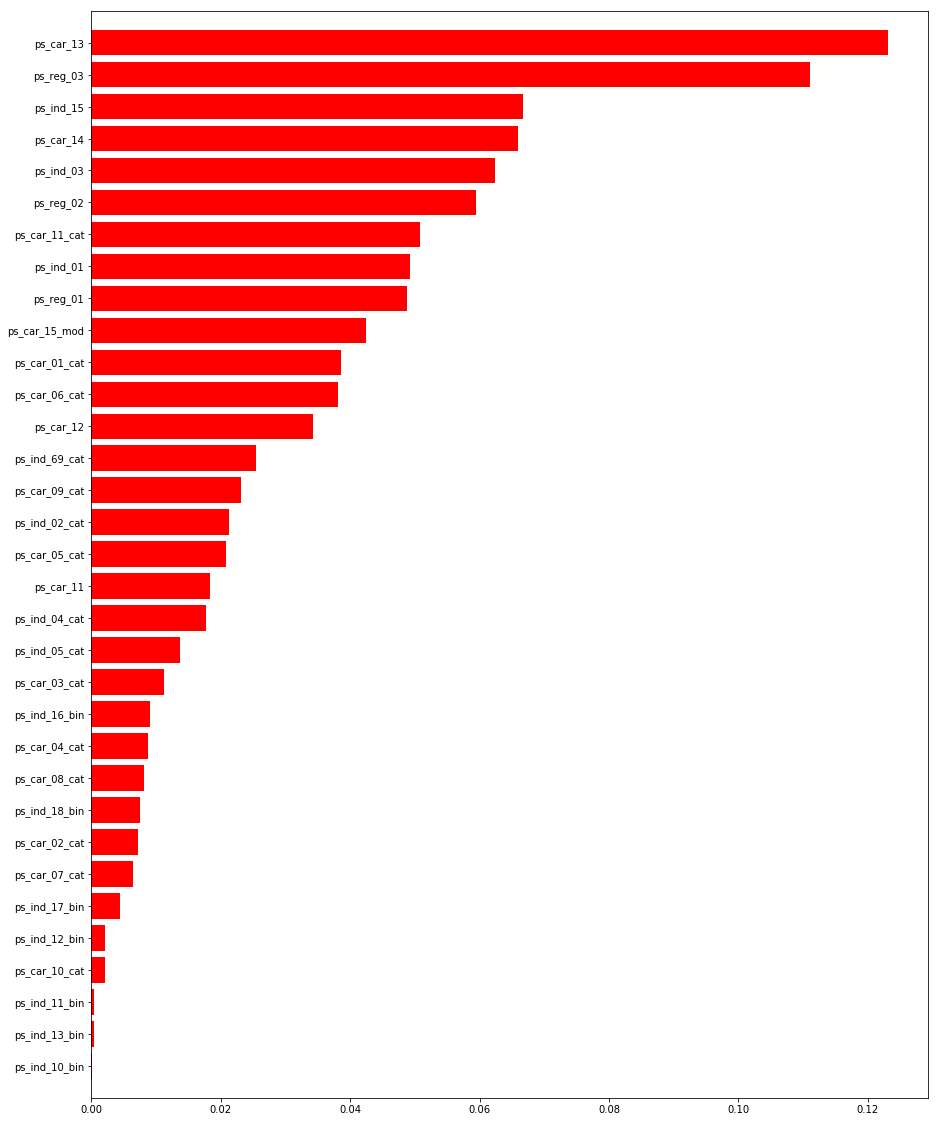

In [18]:
impDict = plotFeatureImportance(rfc.feature_importances_,trainDf2.drop(["target"], axis= 1).columns.tolist())

In [19]:
# order list of features
impList = sorted(impDict, key= impDict.get, reverse= True)

In [30]:
impList[:5]

['ps_car_13', 'ps_reg_03', 'ps_ind_15', 'ps_car_14', 'ps_ind_03']

## Now I will explore the most important features

In [20]:
for fName in impList[:10]:
    print fName, len(trainDf2.loc[:,fName].unique())

ps_car_13 70482
ps_reg_03 5013
ps_ind_15 14
ps_car_14 850
ps_ind_03 12
ps_reg_02 19
ps_car_11_cat 104
ps_ind_01 8
ps_reg_01 10
ps_car_15_mod 13


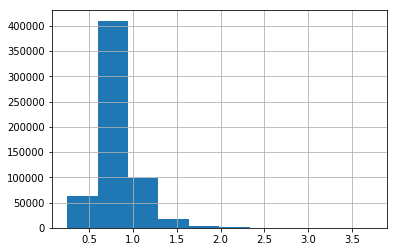

In [38]:
trainDf2.ps_car_13.hist()

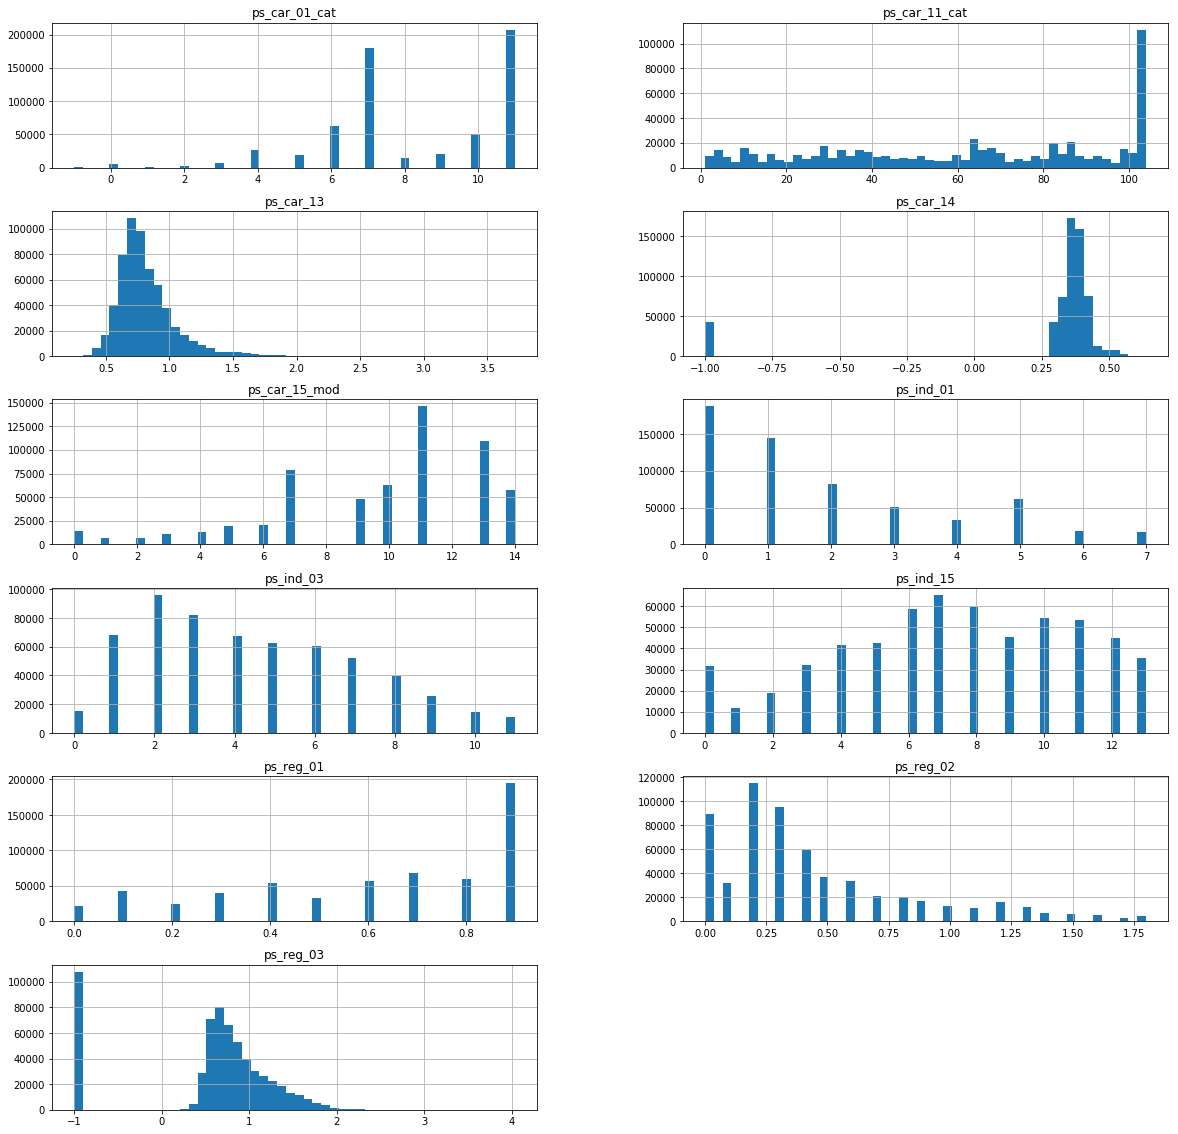

In [47]:
axs = trainDf2.hist(column=impList[:11], grid=True, figsize= [20, 20], layout=[6,2], bins=50)

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [62]:
def scaleDf(df, scaler=None):
    if not scaler:
        scaler = MinMaxScaler(feature_range=[-1, 1])
        res = scaler.fit_transform(df)
    else:
        res = scaler.transform(df)
    return [res, scaler]    

In [66]:
pca = PCA(n_components=7, random_state = 42, svd_solver= 'randomized')
X, scaler = scaleDf(trainDf2.drop("target", axis= 1)) 
transformDf = pca.fit_transform(X, trainDf2.target)
print pca.explained_variance_ratio_

[ 0.14985791  0.12687674  0.08687789  0.07384694  0.06526661  0.05762548
  0.050593  ]


[array([[-0.42857143,  0.2       , -0.09090909, ...,  0.67540111,
          0.85714286, -0.33333333],
        [-0.71428571, -0.2       ,  0.27272727, ...,  0.69728568,
         -0.14285714,  0.33333333],
        [ 0.42857143,  1.        ,  0.63636364, ...,  0.6466369 ,
          0.57142857,  0.33333333],
        ..., 
        [-0.71428571, -0.2       ,  0.81818182, ...,  0.70954702,
         -0.57142857, -1.        ],
        [ 0.42857143,  0.2       , -0.45454545, ...,  0.69270451,
          0.42857143,  0.33333333],
        [-1.        , -0.2       ,  0.45454545, ...,  0.68421467,
          1.        , -1.        ]]),
 MinMaxScaler(copy=True, feature_range=[-1, 1])]

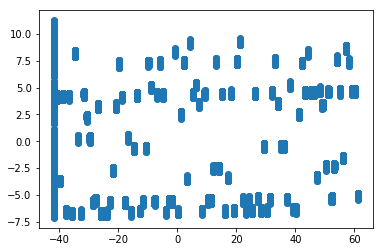

In [54]:
plt.scatter(transformDf[:,0],transformDf[:,1])

In [53]:
transformDf.shape

(595212, 5)

In [44]:
def getCatFeatures(df):
    catFeatures = list()
    for i, fName in enumerate(df.columns.tolist()):
        if fName == 'id' or fName == 'target':
            continue
        if df.loc[:,fName].dtypes != 'int':
            continue
        if len(df.loc[:,fName].unique()) < 20:
            catFeatures.append(i)
    return catFeatures        

In [15]:
def trainCatBoost(trainSet, targetSet, params={'depth': 7, 'rate': 0.03, 'l2': 8, 'T': 1},
                  folds=10, maxIter=1000, verbose=True, dirName =  '/tmp/porto/catboost/'):
    # create log directory
    dirName = dirName + str(params.get('depth')) + '_' + str(params.get('rate')) + \
              '_' + str(params.get('l2')) + '_' + str(params.get('T'))

    try:
        os.makedirs(dirName)
    except Exception as inst:
        print inst  # __str__ allows args to be printed directly

    treeList = list()
    scoreList = list()
    modelList = list()
    prob = np.zeros([trainSet.shape[0]])

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    for i, (train_index, val_index) in enumerate(skf.split(trainSet, targetSet)):
        model = CatBoostClassifier(verbose=verbose, iterations=maxIter, thread_count=4, eval_metric="AUC",
                                   depth=params['depth'], learning_rate=params['rate'],
                                   l2_leaf_reg=params['l2'], bagging_temperature=params['T'],
                                   od_type='Iter', od_wait=20,
                                   train_dir=dirName +"/"+ str(i), random_seed=i)

        # create pool
        cat_features = getCatFeatures(trainSet)
        print cat_features
        trainPool = Pool(trainSet.iloc[train_index], targetSet.iloc[train_index],
                         cat_features= cat_features,
                         feature_names=trainSet.columns.tolist())

        valPool = Pool(trainSet.iloc[val_index], targetSet.iloc[val_index],
                       cat_features= cat_features,
                       feature_names=trainSet.columns.tolist())

        # fit and estimate the model
        model.fit(trainPool, eval_set=valPool, use_best_model=True)
        prob[val_index] = model.predict_proba(valPool)[:, 1]
        localScore = roc_auc_score(targetSet.iloc[val_index], prob[val_index])

        treeList.append(model.tree_count_)
        scoreList.append(localScore)
        modelList.append(model)
        
    score = roc_auc_score(targetSet, prob)
    return [score, treeList, scoreList, modelList]

In [16]:
trainDf2 = trainDf2.assign(ps_reg_01 = trainDf2.ps_reg_01*10)
trainDf2 = trainDf2.assign(ps_reg_02 = trainDf2.ps_reg_02*10)

In [18]:
params = {'depth': 7, 'l2': 5.5, 'rate': 0.055, 'T': 1.5}

getResult = lambda x: trainCatBoost(trainDf2.drop("target",axis = 1), trainDf2.target, x, maxIter=2000, folds=5, verbose= True)
[score, treeList, scoreList, modelList] = getResult(params)

[Errno 17] File exists: '/tmp/porto/catboost/7_0.055_5.5_1.5'
ps_ind_01 1
ps_ind_02_cat 2
ps_ind_03 3
ps_ind_04_cat 4
ps_ind_05_cat 5
ps_ind_10_bin 6
ps_ind_11_bin 7
ps_ind_12_bin 8
ps_ind_13_bin 9
ps_ind_15 10
ps_ind_16_bin 11
ps_ind_17_bin 12
ps_ind_18_bin 13
ps_reg_01 14
ps_reg_02 15
ps_reg_03 16
ps_car_01_cat 17
ps_car_02_cat 18
ps_car_03_cat 19
ps_car_04_cat 20
ps_car_05_cat 21
ps_car_06_cat 22
ps_car_07_cat 23
ps_car_08_cat 24
ps_car_09_cat 25
ps_car_10_cat 26
ps_car_11_cat 27
ps_car_11 28
ps_car_12 29
ps_car_13 30
ps_car_14 31
ps_car_15_mod 32
ps_ind_69_cat 33
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 32, 33]
Borders for float features generated
0:	learn 0.5489128884	test 0.5459425233	bestTest 0.5459425233		total: 3.33s	remaining: 1h 50m 50s
1:	learn 0.5661438151	test 0.5617619951	bestTest 0.5617619951		total: 7.45s	remaining: 2h 4m 6s
2:	learn 0.5779224366	test 0.5678890043	bestTest 0.5678890043		total: 11.2s	remaining: 2h 4

76:	learn 0.635147015	test 0.6174462778	bestTest 0.6174462778		total: 4m 7s	remaining: 1h 42m 59s
77:	learn 0.6353452499	test 0.6175650992	bestTest 0.6175650992		total: 4m 11s	remaining: 1h 43m 9s
78:	learn 0.6354822388	test 0.6177580606	bestTest 0.6177580606		total: 4m 15s	remaining: 1h 43m 34s
79:	learn 0.6355231342	test 0.6176513267	bestTest 0.6177580606		total: 4m 19s	remaining: 1h 43m 55s
80:	learn 0.6356591351	test 0.6177241195	bestTest 0.6177580606		total: 4m 24s	remaining: 1h 44m 26s
81:	learn 0.6359539591	test 0.6179248064	bestTest 0.6179248064		total: 4m 29s	remaining: 1h 44m 57s
82:	learn 0.6360364537	test 0.6180403296	bestTest 0.6180403296		total: 4m 33s	remaining: 1h 45m 24s
83:	learn 0.6360882114	test 0.6180452221	bestTest 0.6180452221		total: 4m 38s	remaining: 1h 45m 44s
84:	learn 0.6363548567	test 0.6181465762	bestTest 0.6181465762		total: 4m 42s	remaining: 1h 45m 58s
85:	learn 0.6366206518	test 0.6182906367	bestTest 0.6182906367		total: 4m 46s	remaining: 1h 46m 18s
86:

158:	learn 0.6450024412	test 0.6233600162	bestTest 0.6233600162		total: 10m 1s	remaining: 1h 56m 7s
159:	learn 0.645068435	test 0.6233796726	bestTest 0.6233796726		total: 10m 6s	remaining: 1h 56m 12s
160:	learn 0.6450813342	test 0.6233811775	bestTest 0.6233811775		total: 10m 10s	remaining: 1h 56m 16s
161:	learn 0.6452031828	test 0.6234949688	bestTest 0.6234949688		total: 10m 15s	remaining: 1h 56m 17s
162:	learn 0.6452848128	test 0.6235411733	bestTest 0.6235411733		total: 10m 19s	remaining: 1h 56m 20s
163:	learn 0.6453904806	test 0.6235862265	bestTest 0.6235862265		total: 10m 23s	remaining: 1h 56m 20s
164:	learn 0.645567608	test 0.6237193105	bestTest 0.6237193105		total: 10m 27s	remaining: 1h 56m 22s
165:	learn 0.6457760907	test 0.6237593587	bestTest 0.6237593587		total: 10m 32s	remaining: 1h 56m 25s
166:	learn 0.6458097223	test 0.6237776227	bestTest 0.6237776227		total: 10m 36s	remaining: 1h 56m 28s
167:	learn 0.6461414815	test 0.6239529288	bestTest 0.6239529288		total: 10m 40s	remaini

240:	learn 0.6520315317	test 0.6262058132	bestTest 0.6262770889		total: 15m 56s	remaining: 1h 56m 18s
241:	learn 0.6520307846	test 0.6261985678	bestTest 0.6262770889		total: 16m 1s	remaining: 1h 56m 24s
242:	learn 0.6521323732	test 0.6262455861	bestTest 0.6262770889		total: 16m 5s	remaining: 1h 56m 21s
243:	learn 0.6521630405	test 0.6262624355	bestTest 0.6262770889		total: 16m 10s	remaining: 1h 56m 24s
244:	learn 0.6521673649	test 0.6262621362	bestTest 0.6262770889		total: 16m 15s	remaining: 1h 56m 29s
245:	learn 0.6523381886	test 0.6263659435	bestTest 0.6263659435		total: 16m 19s	remaining: 1h 56m 27s
246:	learn 0.6524211575	test 0.6264325378	bestTest 0.6264325378		total: 16m 23s	remaining: 1h 56m 22s
247:	learn 0.6524253465	test 0.6264224112	bestTest 0.6264325378		total: 16m 29s	remaining: 1h 56m 27s
248:	learn 0.6525045878	test 0.6264350353	bestTest 0.6264350353		total: 16m 33s	remaining: 1h 56m 25s
249:	learn 0.6525450677	test 0.6264302211	bestTest 0.6264350353		total: 16m 38s	rema

321:	learn 0.656233123	test 0.6279517884	bestTest 0.6279518265		total: 22m 11s	remaining: 1h 55m 40s
322:	learn 0.6563396777	test 0.6280645931	bestTest 0.6280645931		total: 22m 16s	remaining: 1h 55m 38s
323:	learn 0.6563671906	test 0.6280646614	bestTest 0.6280646614		total: 22m 20s	remaining: 1h 55m 34s
324:	learn 0.6563849726	test 0.6280726763	bestTest 0.6280726763		total: 22m 25s	remaining: 1h 55m 34s
325:	learn 0.6563963007	test 0.6280513623	bestTest 0.6280726763		total: 22m 29s	remaining: 1h 55m 30s
326:	learn 0.6564432401	test 0.6280746453	bestTest 0.6280746453		total: 22m 34s	remaining: 1h 55m 30s
327:	learn 0.656462233	test 0.628091105	bestTest 0.628091105		total: 22m 38s	remaining: 1h 55m 27s
328:	learn 0.6565020182	test 0.6281039119	bestTest 0.6281039119		total: 22m 43s	remaining: 1h 55m 26s
329:	learn 0.656518928	test 0.6281030861	bestTest 0.6281039119		total: 22m 48s	remaining: 1h 55m 27s
330:	learn 0.656541517	test 0.6280866465	bestTest 0.6281039119		total: 22m 54s	remainin

38:	learn 0.6184221255	test 0.6199161701	bestTest 0.6201045413		total: 2m 1s	remaining: 1h 41m 44s
39:	learn 0.6188275634	test 0.6202184522	bestTest 0.6202184522		total: 2m 5s	remaining: 1h 42m 49s
40:	learn 0.619515017	test 0.6211094807	bestTest 0.6211094807		total: 2m 11s	remaining: 1h 44m 37s
41:	learn 0.619515017	test 0.6211094807	bestTest 0.6211094807		total: 2m 11s	remaining: 1h 42m 27s
42:	learn 0.6200574356	test 0.6215220811	bestTest 0.6215220811		total: 2m 16s	remaining: 1h 43m 22s
43:	learn 0.6200639275	test 0.6214165016	bestTest 0.6215220811		total: 2m 17s	remaining: 1h 41m 39s
44:	learn 0.6201860505	test 0.621746672	bestTest 0.621746672		total: 2m 22s	remaining: 1h 43m 8s
45:	learn 0.6208031278	test 0.6220168605	bestTest 0.6220168605		total: 2m 28s	remaining: 1h 45m 5s
46:	learn 0.6213189522	test 0.6222702417	bestTest 0.6222702417		total: 2m 34s	remaining: 1h 46m 53s
47:	learn 0.6221513597	test 0.6230727472	bestTest 0.6230727472		total: 2m 39s	remaining: 1h 47m 52s
48:	lear

121:	learn 0.6385159806	test 0.6352495254	bestTest 0.6352495254		total: 8m 27s	remaining: 2h 10m 6s
122:	learn 0.6386913258	test 0.6352705762	bestTest 0.6352705762		total: 8m 31s	remaining: 2h 10m 8s
123:	learn 0.6390344626	test 0.6353721352	bestTest 0.6353721352		total: 8m 35s	remaining: 2h 9m 59s
124:	learn 0.6391754927	test 0.6353793624	bestTest 0.6353793624		total: 8m 39s	remaining: 2h 9m 54s
125:	learn 0.6394198813	test 0.6355852312	bestTest 0.6355852312		total: 8m 44s	remaining: 2h 9m 55s
126:	learn 0.6394410831	test 0.6355805557	bestTest 0.6355852312		total: 8m 48s	remaining: 2h 10m
127:	learn 0.6394879413	test 0.6356001659	bestTest 0.6356001659		total: 8m 54s	remaining: 2h 10m 10s
128:	learn 0.6395218364	test 0.6355839412	bestTest 0.6356001659		total: 8m 56s	remaining: 2h 9m 46s
129:	learn 0.6396205647	test 0.6356534409	bestTest 0.6356534409		total: 9m 1s	remaining: 2h 9m 53s
130:	learn 0.6396628135	test 0.6356398504	bestTest 0.6356534409		total: 9m 6s	remaining: 2h 9m 57s
131:

203:	learn 0.646681111	test 0.6392365585	bestTest 0.6392446356		total: 14m 51s	remaining: 2h 10m 48s
204:	learn 0.6467764368	test 0.639267105	bestTest 0.639267105		total: 14m 56s	remaining: 2h 10m 48s
205:	learn 0.646810919	test 0.6392783447	bestTest 0.6392783447		total: 15m 1s	remaining: 2h 10m 51s
206:	learn 0.6468685726	test 0.6392952584	bestTest 0.6392952584		total: 15m 6s	remaining: 2h 10m 47s
207:	learn 0.6469261326	test 0.6393475268	bestTest 0.6393475268		total: 15m 11s	remaining: 2h 10m 52s
208:	learn 0.6470011525	test 0.6394126664	bestTest 0.6394126664		total: 15m 16s	remaining: 2h 10m 54s
209:	learn 0.6471000977	test 0.6394716637	bestTest 0.6394716637		total: 15m 21s	remaining: 2h 10m 52s
210:	learn 0.6471349705	test 0.6394788427	bestTest 0.6394788427		total: 15m 26s	remaining: 2h 10m 54s
211:	learn 0.6471848963	test 0.6395203877	bestTest 0.6395203877		total: 15m 30s	remaining: 2h 10m 51s
212:	learn 0.647284577	test 0.6395475024	bestTest 0.6395475024		total: 15m 34s	remaining

285:	learn 0.6523212301	test 0.6404397968	bestTest 0.6404856979		total: 21m 26s	remaining: 2h 8m 29s
286:	learn 0.6523968673	test 0.6404572812	bestTest 0.6404856979		total: 21m 31s	remaining: 2h 8m 26s
287:	learn 0.6524380196	test 0.6404658526	bestTest 0.6404856979		total: 21m 35s	remaining: 2h 8m 22s
288:	learn 0.6524383695	test 0.6404706065	bestTest 0.6404856979		total: 21m 41s	remaining: 2h 8m 23s
289:	learn 0.652480288	test 0.640493556	bestTest 0.640493556		total: 21m 45s	remaining: 2h 8m 17s
290:	learn 0.6525065849	test 0.6405240322	bestTest 0.6405240322		total: 21m 49s	remaining: 2h 8m 11s
291:	learn 0.6525699841	test 0.6405546429	bestTest 0.6405546429		total: 21m 54s	remaining: 2h 8m 8s
292:	learn 0.6525989196	test 0.6405656536	bestTest 0.6405656536		total: 21m 59s	remaining: 2h 8m 5s
293:	learn 0.652613862	test 0.6405671304	bestTest 0.6405671304		total: 22m 4s	remaining: 2h 8m 3s
294:	learn 0.6526525658	test 0.6405568049	bestTest 0.6405671304		total: 22m 9s	remaining: 2h 8m 1s


367:	learn 0.6558178308	test 0.6414866208	bestTest 0.6414866208		total: 28m 16s	remaining: 2h 5m 25s
368:	learn 0.6558756391	test 0.6414882764	bestTest 0.6414882764		total: 28m 19s	remaining: 2h 5m 13s
369:	learn 0.6559030552	test 0.6414876857	bestTest 0.6414882764		total: 28m 25s	remaining: 2h 5m 12s
370:	learn 0.6559466587	test 0.6414979027	bestTest 0.6414979027		total: 28m 29s	remaining: 2h 5m 7s
371:	learn 0.6559835219	test 0.6414914109	bestTest 0.6414979027		total: 28m 35s	remaining: 2h 5m 7s
372:	learn 0.6559924488	test 0.6414846518	bestTest 0.6414979027		total: 28m 40s	remaining: 2h 5m 6s
373:	learn 0.6560038164	test 0.6414831408	bestTest 0.6414979027		total: 28m 46s	remaining: 2h 5m 5s
374:	learn 0.6560300764	test 0.6414916218	bestTest 0.6414979027		total: 28m 51s	remaining: 2h 5m 4s
375:	learn 0.6561370362	test 0.6415275772	bestTest 0.6415275772		total: 28m 56s	remaining: 2h 5m
376:	learn 0.6561654557	test 0.6415312219	bestTest 0.6415312219		total: 29m 1s	remaining: 2h 4m 55s


19:	learn 0.6188028932	test 0.6147881167	bestTest 0.6147881167		total: 52.4s	remaining: 1h 26m 26s
20:	learn 0.6188028932	test 0.6147881167	bestTest 0.6147881167		total: 52.9s	remaining: 1h 23m 2s
21:	learn 0.6189129827	test 0.615766286	bestTest 0.615766286		total: 55.1s	remaining: 1h 22m 33s
22:	learn 0.6189129827	test 0.615766286	bestTest 0.615766286		total: 55.6s	remaining: 1h 19m 41s
23:	learn 0.6199243416	test 0.6171410923	bestTest 0.6171410923		total: 56.5s	remaining: 1h 17m 35s
24:	learn 0.6198450996	test 0.616523235	bestTest 0.6171410923		total: 1m 1s	remaining: 1h 20m 39s
25:	learn 0.620796726	test 0.6183632768	bestTest 0.6183632768		total: 1m 5s	remaining: 1h 22m 52s
26:	learn 0.6207376466	test 0.6185321775	bestTest 0.6185321775		total: 1m 10s	remaining: 1h 26m 25s
27:	learn 0.6202778637	test 0.6180199057	bestTest 0.6185321775		total: 1m 11s	remaining: 1h 24m 22s
28:	learn 0.6203147055	test 0.6185207228	bestTest 0.6185321775		total: 1m 16s	remaining: 1h 26m 39s
29:	learn 0.62

185:	learn 0.6458200053	test 0.6364017873	bestTest 0.6364017873		total: 13m 16s	remaining: 2h 9m 31s
186:	learn 0.6458200053	test 0.6364017873	bestTest 0.6364017873		total: 13m 17s	remaining: 2h 8m 50s
187:	learn 0.6458822735	test 0.6364103808	bestTest 0.6364103808		total: 13m 21s	remaining: 2h 8m 47s
188:	learn 0.6458846223	test 0.6364102582	bestTest 0.6364103808		total: 13m 27s	remaining: 2h 8m 55s
189:	learn 0.6459375341	test 0.6364411	bestTest 0.6364411		total: 13m 31s	remaining: 2h 8m 54s
190:	learn 0.6459792643	test 0.636457831	bestTest 0.636457831		total: 13m 36s	remaining: 2h 8m 53s
191:	learn 0.6460773029	test 0.6364639592	bestTest 0.6364639592		total: 13m 41s	remaining: 2h 8m 52s
192:	learn 0.6460937435	test 0.6364591008	bestTest 0.6364639592		total: 13m 45s	remaining: 2h 8m 52s
193:	learn 0.6461782281	test 0.636506111	bestTest 0.636506111		total: 13m 51s	remaining: 2h 8m 57s
194:	learn 0.6462909401	test 0.636592432	bestTest 0.636592432		total: 13m 55s	remaining: 2h 8m 49s
19

267:	learn 0.6506729602	test 0.6381571456	bestTest 0.6381687972		total: 19m 50s	remaining: 2h 8m 10s
268:	learn 0.6507310973	test 0.6381356307	bestTest 0.6381687972		total: 19m 54s	remaining: 2h 8m 4s
269:	learn 0.6507492515	test 0.6381452429	bestTest 0.6381687972		total: 19m 58s	remaining: 2h 7m 57s
270:	learn 0.6508394476	test 0.6381240735	bestTest 0.6381687972		total: 20m 3s	remaining: 2h 7m 59s
271:	learn 0.6508595341	test 0.6381092313	bestTest 0.6381687972		total: 20m 8s	remaining: 2h 7m 56s
272:	learn 0.6509166968	test 0.638111992	bestTest 0.6381687972		total: 20m 13s	remaining: 2h 7m 56s
273:	learn 0.6509201213	test 0.6381048592	bestTest 0.6381687972		total: 20m 19s	remaining: 2h 8m 2s
274:	learn 0.6509866358	test 0.6381414293	bestTest 0.6381687972		total: 20m 24s	remaining: 2h 7m 58s
275:	learn 0.6510058281	test 0.6381532296	bestTest 0.6381687972		total: 20m 28s	remaining: 2h 7m 56s
276:	learn 0.6511259531	test 0.6381362174	bestTest 0.6381687972		total: 20m 33s	remaining: 2h 7m

349:	learn 0.654939344	test 0.6390732907	bestTest 0.6390732907		total: 26m 39s	remaining: 2h 5m 39s
350:	learn 0.6549380421	test 0.6390732766	bestTest 0.6390732907		total: 26m 44s	remaining: 2h 5m 35s
351:	learn 0.6550515826	test 0.6391341385	bestTest 0.6391341385		total: 26m 49s	remaining: 2h 5m 34s
352:	learn 0.6550527713	test 0.6391454425	bestTest 0.6391454425		total: 26m 55s	remaining: 2h 5m 36s
353:	learn 0.6550657436	test 0.6391587617	bestTest 0.6391587617		total: 27m 1s	remaining: 2h 5m 37s
354:	learn 0.6552217002	test 0.639129252	bestTest 0.6391587617		total: 27m 6s	remaining: 2h 5m 34s
355:	learn 0.655265712	test 0.6391259689	bestTest 0.6391587617		total: 27m 11s	remaining: 2h 5m 35s
356:	learn 0.65529082	test 0.6391260734	bestTest 0.6391587617		total: 27m 17s	remaining: 2h 5m 34s
357:	learn 0.6553454312	test 0.6391484744	bestTest 0.6391587617		total: 27m 21s	remaining: 2h 5m 30s
358:	learn 0.655380659	test 0.6390769837	bestTest 0.6391587617		total: 27m 25s	remaining: 2h 5m 23

431:	learn 0.6583688344	test 0.6397148088	bestTest 0.6397148088		total: 33m 29s	remaining: 2h 1m 34s
432:	learn 0.6583899489	test 0.6397182607	bestTest 0.6397182607		total: 33m 35s	remaining: 2h 1m 32s
433:	learn 0.6584263129	test 0.6397183672	bestTest 0.6397183672		total: 33m 40s	remaining: 2h 1m 30s
434:	learn 0.6584692606	test 0.6397523032	bestTest 0.6397523032		total: 33m 44s	remaining: 2h 1m 25s
435:	learn 0.6585017388	test 0.639748345	bestTest 0.6397523032		total: 33m 50s	remaining: 2h 1m 23s
436:	learn 0.6585379326	test 0.6397442181	bestTest 0.6397523032		total: 33m 54s	remaining: 2h 1m 16s
437:	learn 0.6585369478	test 0.6397438122	bestTest 0.6397523032		total: 34m	remaining: 2h 1m 16s
438:	learn 0.6585451889	test 0.6397556928	bestTest 0.6397556928		total: 34m 5s	remaining: 2h 1m 13s
439:	learn 0.6585593118	test 0.6397510254	bestTest 0.6397556928		total: 34m 10s	remaining: 2h 1m 8s
440:	learn 0.6586494603	test 0.639726147	bestTest 0.6397556928		total: 34m 15s	remaining: 2h 1m 4s

513:	learn 0.6612378904	test 0.6402857544	bestTest 0.6403138215		total: 40m 22s	remaining: 1h 56m 42s
514:	learn 0.661261116	test 0.6402867711	bestTest 0.6403138215		total: 40m 26s	remaining: 1h 56m 36s
515:	learn 0.661319418	test 0.6403136105	bestTest 0.6403138215		total: 40m 31s	remaining: 1h 56m 33s
516:	learn 0.6613749867	test 0.6403213682	bestTest 0.6403213682		total: 40m 36s	remaining: 1h 56m 28s
517:	learn 0.6614229261	test 0.6403471528	bestTest 0.6403471528		total: 40m 41s	remaining: 1h 56m 25s
518:	learn 0.6614303159	test 0.6403474542	bestTest 0.6403474542		total: 40m 47s	remaining: 1h 56m 24s
519:	learn 0.6614940229	test 0.6403830619	bestTest 0.6403830619		total: 40m 52s	remaining: 1h 56m 21s
520:	learn 0.6615729679	test 0.6404001826	bestTest 0.6404001826		total: 40m 57s	remaining: 1h 56m 16s
521:	learn 0.6616093691	test 0.6403921537	bestTest 0.6404001826		total: 41m 2s	remaining: 1h 56m 12s
522:	learn 0.6616127327	test 0.6403920934	bestTest 0.6404001826		total: 41m 7s	remain

46:	learn 0.6243530023	test 0.6265615132	bestTest 0.6265615132		total: 2m 18s	remaining: 1h 36m 8s
47:	learn 0.6243657062	test 0.6265731398	bestTest 0.6265731398		total: 2m 22s	remaining: 1h 36m 33s
48:	learn 0.6249840855	test 0.6270140834	bestTest 0.6270140834		total: 2m 26s	remaining: 1h 37m 22s
49:	learn 0.6254294255	test 0.6272046514	bestTest 0.6272046514		total: 2m 30s	remaining: 1h 37m 53s
50:	learn 0.6255276584	test 0.6271825234	bestTest 0.6272046514		total: 2m 35s	remaining: 1h 38m 53s
51:	learn 0.6256089416	test 0.6270841643	bestTest 0.6272046514		total: 2m 39s	remaining: 1h 39m 50s
52:	learn 0.6257589926	test 0.6272800468	bestTest 0.6272800468		total: 2m 41s	remaining: 1h 38m 42s
53:	learn 0.6261843736	test 0.6275203419	bestTest 0.6275203419		total: 2m 43s	remaining: 1h 37m 59s
54:	learn 0.6268250466	test 0.628003279	bestTest 0.628003279		total: 2m 47s	remaining: 1h 38m 35s
55:	learn 0.6272689821	test 0.6283680878	bestTest 0.6283680878		total: 2m 51s	remaining: 1h 39m 26s
56:

129:	learn 0.6410045571	test 0.6368363622	bestTest 0.6368363622		total: 8m 28s	remaining: 2h 1m 59s
130:	learn 0.6411014608	test 0.6369108996	bestTest 0.6369108996		total: 8m 33s	remaining: 2h 2m 7s
131:	learn 0.6411675015	test 0.6369197122	bestTest 0.6369197122		total: 8m 38s	remaining: 2h 2m 19s
132:	learn 0.6412843414	test 0.6370076152	bestTest 0.6370076152		total: 8m 43s	remaining: 2h 2m 24s
133:	learn 0.6413921244	test 0.6371029505	bestTest 0.6371029505		total: 8m 47s	remaining: 2h 2m 22s
134:	learn 0.6416715038	test 0.637261083	bestTest 0.637261083		total: 8m 51s	remaining: 2h 2m 17s
135:	learn 0.6417129161	test 0.637311638	bestTest 0.637311638		total: 8m 54s	remaining: 2h 2m 7s
136:	learn 0.6417594894	test 0.6373333159	bestTest 0.6373333159		total: 8m 59s	remaining: 2h 2m 11s
137:	learn 0.6418432201	test 0.6374132461	bestTest 0.6374132461		total: 9m 3s	remaining: 2h 2m 12s
138:	learn 0.6419164151	test 0.6374843316	bestTest 0.6374843316		total: 9m 7s	remaining: 2h 2m 5s
139:	lear

211:	learn 0.6474844687	test 0.6392514273	bestTest 0.6392767138		total: 14m 49s	remaining: 2h 5m 2s
212:	learn 0.6475026083	test 0.639251572	bestTest 0.6392767138		total: 14m 54s	remaining: 2h 5m 3s
213:	learn 0.6477551963	test 0.6394718649	bestTest 0.6394718649		total: 14m 57s	remaining: 2h 4m 53s
214:	learn 0.6477885801	test 0.639508353	bestTest 0.639508353		total: 15m 3s	remaining: 2h 5m 2s
215:	learn 0.6478520303	test 0.6395146099	bestTest 0.6395146099		total: 15m 8s	remaining: 2h 5m 7s
216:	learn 0.6479264879	test 0.6395060384	bestTest 0.6395146099		total: 15m 14s	remaining: 2h 5m 14s
217:	learn 0.6479554013	test 0.6395154779	bestTest 0.6395154779		total: 15m 20s	remaining: 2h 5m 21s
218:	learn 0.6480148564	test 0.6395295407	bestTest 0.6395295407		total: 15m 26s	remaining: 2h 5m 32s
219:	learn 0.6481419488	test 0.6396166199	bestTest 0.6396166199		total: 15m 31s	remaining: 2h 5m 38s
220:	learn 0.6481737169	test 0.639628372	bestTest 0.639628372		total: 15m 38s	remaining: 2h 5m 51s
2

294:	learn 0.6534470482	test 0.6410472151	bestTest 0.6410472151		total: 21m 40s	remaining: 2h 5m 15s
295:	learn 0.6534392894	test 0.64104566	bestTest 0.6410472151		total: 21m 45s	remaining: 2h 5m 16s
296:	learn 0.6534434068	test 0.641049789	bestTest 0.641049789		total: 21m 51s	remaining: 2h 5m 21s
297:	learn 0.6535620496	test 0.6410053322	bestTest 0.641049789		total: 21m 56s	remaining: 2h 5m 17s
298:	learn 0.6536378086	test 0.6409829511	bestTest 0.641049789		total: 22m	remaining: 2h 5m 14s
299:	learn 0.6536730038	test 0.6409799372	bestTest 0.641049789		total: 22m 6s	remaining: 2h 5m 16s
300:	learn 0.6536942717	test 0.6409749823	bestTest 0.641049789		total: 22m 11s	remaining: 2h 5m 13s
301:	learn 0.6537166238	test 0.6409696799	bestTest 0.641049789		total: 22m 15s	remaining: 2h 5m 8s
302:	learn 0.6537587159	test 0.6409671241	bestTest 0.641049789		total: 22m 19s	remaining: 2h 5m 3s
303:	learn 0.6537567261	test 0.6409628384	bestTest 0.641049789		total: 22m 25s	remaining: 2h 5m 5s
304:	lear

52:	learn 0.6258352536	test 0.6279609811	bestTest 0.6279609811		total: 2m 34s	remaining: 1h 34m 26s
53:	learn 0.6262392924	test 0.6282140873	bestTest 0.6282140873		total: 2m 38s	remaining: 1h 35m 6s
54:	learn 0.6265860256	test 0.6284087378	bestTest 0.6284087378		total: 2m 42s	remaining: 1h 35m 55s
55:	learn 0.6270287747	test 0.6286534976	bestTest 0.6286534976		total: 2m 47s	remaining: 1h 36m 48s
56:	learn 0.6274345808	test 0.6288393687	bestTest 0.6288393687		total: 2m 51s	remaining: 1h 37m 39s
57:	learn 0.6279374846	test 0.6292479338	bestTest 0.6292479338		total: 2m 56s	remaining: 1h 38m 14s
58:	learn 0.6284433112	test 0.6295328298	bestTest 0.6295328298		total: 3m	remaining: 1h 38m 50s
59:	learn 0.6286172009	test 0.6296190468	bestTest 0.6296190468		total: 3m 4s	remaining: 1h 39m 36s
60:	learn 0.6289372478	test 0.6300502303	bestTest 0.6300502303		total: 3m 9s	remaining: 1h 40m 20s
61:	learn 0.6291041597	test 0.6301096467	bestTest 0.6301096467		total: 3m 13s	remaining: 1h 41m 1s
62:	lear

135:	learn 0.6425202568	test 0.638084031	bestTest 0.6380977192		total: 8m 49s	remaining: 2h 57s
136:	learn 0.6426098366	test 0.6381398268	bestTest 0.6381398268		total: 8m 54s	remaining: 2h 1m 5s
137:	learn 0.6428577983	test 0.638186165	bestTest 0.638186165		total: 8m 58s	remaining: 2h 1m 7s
138:	learn 0.6429374313	test 0.638164265	bestTest 0.638186165		total: 9m 2s	remaining: 2h 1m 5s
139:	learn 0.6430620693	test 0.6382542824	bestTest 0.6382542824		total: 9m 7s	remaining: 2h 1m 19s
140:	learn 0.6431241589	test 0.6382747937	bestTest 0.6382747937		total: 9m 12s	remaining: 2h 1m 29s
141:	learn 0.6431937235	test 0.6382718976	bestTest 0.6382747937		total: 9m 17s	remaining: 2h 1m 39s
142:	learn 0.6433245452	test 0.6382877965	bestTest 0.6382877965		total: 9m 22s	remaining: 2h 1m 47s
143:	learn 0.6433440465	test 0.6382611798	bestTest 0.6382877965		total: 9m 28s	remaining: 2h 2m 5s
144:	learn 0.6434053363	test 0.6382916753	bestTest 0.6382916753		total: 9m 32s	remaining: 2h 2m 9s
145:	learn 0.64

217:	learn 0.6496657534	test 0.6403725279	bestTest 0.6403725279		total: 15m 18s	remaining: 2h 5m 8s
218:	learn 0.6497813804	test 0.6403839713	bestTest 0.6403839713		total: 15m 23s	remaining: 2h 5m 7s
219:	learn 0.6497819749	test 0.6403778878	bestTest 0.6403839713		total: 15m 28s	remaining: 2h 5m 12s
220:	learn 0.6498112935	test 0.6403811134	bestTest 0.6403839713		total: 15m 33s	remaining: 2h 5m 16s
221:	learn 0.6498832979	test 0.640365719	bestTest 0.6403839713		total: 15m 39s	remaining: 2h 5m 20s
222:	learn 0.6498857957	test 0.6403656989	bestTest 0.6403839713		total: 15m 44s	remaining: 2h 5m 28s
223:	learn 0.6499326467	test 0.6403637113	bestTest 0.6403839713		total: 15m 49s	remaining: 2h 5m 28s
224:	learn 0.650054098	test 0.6403304906	bestTest 0.6403839713		total: 15m 54s	remaining: 2h 5m 30s
225:	learn 0.6500541663	test 0.6403256612	bestTest 0.6403839713		total: 16m	remaining: 2h 5m 35s
226:	learn 0.6501366269	test 0.6403414536	bestTest 0.6403839713		total: 16m 4s	remaining: 2h 5m 36s

299:	learn 0.6540488547	test 0.6410870881	bestTest 0.6411518774		total: 21m 50s	remaining: 2h 3m 43s
300:	learn 0.6540534742	test 0.6410799274	bestTest 0.6411518774		total: 21m 54s	remaining: 2h 3m 40s
301:	learn 0.6540983904	test 0.6410923154	bestTest 0.6411518774		total: 21m 58s	remaining: 2h 3m 33s
302:	learn 0.6541398035	test 0.641080665	bestTest 0.6411518774		total: 22m 4s	remaining: 2h 3m 35s
303:	learn 0.6542274594	test 0.6411331991	bestTest 0.6411518774		total: 22m 9s	remaining: 2h 3m 34s
304:	learn 0.654247743	test 0.6411620969	bestTest 0.6411620969		total: 22m 13s	remaining: 2h 3m 32s
305:	learn 0.6542770568	test 0.6411549383	bestTest 0.6411620969		total: 22m 18s	remaining: 2h 3m 32s
306:	learn 0.654332258	test 0.6411704372	bestTest 0.6411704372		total: 22m 23s	remaining: 2h 3m 30s
307:	learn 0.65436438	test 0.6411602861	bestTest 0.6411704372		total: 22m 28s	remaining: 2h 3m 29s
308:	learn 0.6543821432	test 0.641162736	bestTest 0.6411704372		total: 22m 32s	remaining: 2h 3m 24

In [20]:
2*score-1

0.27713066579721568

In [24]:
np.array(treeList).mean()

394.19999999999999

In [45]:
testDf2 = processData(pd.read_csv('./data/test.csv'))
trainDf2 = processData(pd.read_csv('./data/train.csv'))

In [47]:
cat_features = getCatFeatures(trainDf2.drop('target',axis = 1))

trainPool = Pool(trainDf2.drop("target", axis = 1), trainDf2.target, cat_features= cat_features,
                 feature_names=trainDf2.drop("target", axis = 1).columns.tolist())
testPool  = Pool(testDf2, cat_features= cat_features,
                       feature_names=testDf2.columns.tolist())

modelAmount = 5
prob = np.zeros([testDf2.shape[0], modelAmount])

for seed in range(0, modelAmount):
    model2 = CatBoostClassifier(verbose=True, iterations= 500, thread_count=4, eval_metric="AUC",
                                       depth=params['depth'], learning_rate=params['rate'],
                                       l2_leaf_reg=params['l2'], bagging_temperature=params['T'],
                                       train_dir= '/tmp/porto/catboost/', random_seed= seed)
    
    model2.fit(trainPool)
    prob[:,seed] = model2.predict_proba(testPool)[:,1]

Borders for float features generated
0:	learn 0.5838435523	total: 24.9s	remaining: 3h 26m 54s
1:	learn 0.5858993735	total: 32.7s	remaining: 2h 15m 42s
2:	learn 0.5884913066	total: 41.8s	remaining: 1h 55m 28s
3:	learn 0.5873259332	total: 50.5s	remaining: 1h 44m 21s
4:	learn 0.5873259332	total: 51.2s	remaining: 1h 24m 27s
5:	learn 0.5873263138	total: 52.2s	remaining: 1h 11m 40s
6:	learn 0.594568244	total: 53.7s	remaining: 1h 3m 2s
7:	learn 0.5949996002	total: 1m 1s	remaining: 1h 3m 24s
8:	learn 0.6007501893	total: 1m 7s	remaining: 1h 1m 43s
9:	learn 0.6016231386	total: 1m 11s	remaining: 58m
10:	learn 0.6019634045	total: 1m 13s	remaining: 54m 41s
11:	learn 0.600574761	total: 1m 18s	remaining: 53m 5s
12:	learn 0.6012739313	total: 1m 23s	remaining: 51m 53s
13:	learn 0.6012739316	total: 1m 24s	remaining: 48m 59s
14:	learn 0.6009118693	total: 1m 26s	remaining: 46m 27s
15:	learn 0.6009118693	total: 1m 26s	remaining: 43m 41s
16:	learn 0.6033824622	total: 1m 30s	remaining: 43m 1s
17:	learn 0.604

146:	learn 0.6425581419	total: 10m 5s	remaining: 24m 13s
147:	learn 0.6426210127	total: 10m 10s	remaining: 24m 12s
148:	learn 0.6427179314	total: 10m 14s	remaining: 24m 7s
149:	learn 0.6427515046	total: 10m 19s	remaining: 24m 5s
150:	learn 0.6427629743	total: 10m 23s	remaining: 24m 1s
151:	learn 0.642809684	total: 10m 28s	remaining: 23m 58s
152:	learn 0.6428097263	total: 10m 33s	remaining: 23m 56s
153:	learn 0.6428493769	total: 10m 37s	remaining: 23m 52s
154:	learn 0.6429211807	total: 10m 41s	remaining: 23m 47s
155:	learn 0.6430465915	total: 10m 45s	remaining: 23m 43s
156:	learn 0.6431105452	total: 10m 50s	remaining: 23m 41s
157:	learn 0.6432563626	total: 10m 54s	remaining: 23m 37s
158:	learn 0.6433161587	total: 10m 59s	remaining: 23m 34s
159:	learn 0.6434835865	total: 11m 4s	remaining: 23m 31s
160:	learn 0.6435374663	total: 11m 8s	remaining: 23m 27s
161:	learn 0.6435457421	total: 11m 13s	remaining: 23m 25s
162:	learn 0.6436426893	total: 11m 18s	remaining: 23m 22s
163:	learn 0.64369702

289:	learn 0.6511671735	total: 21m 18s	remaining: 15m 26s
290:	learn 0.6511726161	total: 21m 24s	remaining: 15m 22s
291:	learn 0.65117082	total: 21m 31s	remaining: 15m 20s
292:	learn 0.6511941686	total: 21m 38s	remaining: 15m 17s
293:	learn 0.6512525842	total: 21m 44s	remaining: 15m 14s
294:	learn 0.6513163964	total: 21m 50s	remaining: 15m 10s
295:	learn 0.6513529232	total: 21m 56s	remaining: 15m 7s
296:	learn 0.6513804533	total: 22m 1s	remaining: 15m 3s
297:	learn 0.6514571602	total: 22m 7s	remaining: 14m 59s
298:	learn 0.6514981196	total: 22m 11s	remaining: 14m 55s
299:	learn 0.6516009787	total: 22m 16s	remaining: 14m 50s
300:	learn 0.6516043846	total: 22m 22s	remaining: 14m 47s
301:	learn 0.6516332975	total: 22m 27s	remaining: 14m 43s
302:	learn 0.651649668	total: 22m 33s	remaining: 14m 40s
303:	learn 0.651716854	total: 22m 39s	remaining: 14m 36s
304:	learn 0.6517626687	total: 22m 44s	remaining: 14m 32s
305:	learn 0.6517719428	total: 22m 51s	remaining: 14m 29s
306:	learn 0.651839435

433:	learn 0.6564404693	total: 34m	remaining: 5m 10s
434:	learn 0.6564399357	total: 34m 5s	remaining: 5m 5s
435:	learn 0.6565091675	total: 34m 8s	remaining: 5m
436:	learn 0.656524275	total: 34m 13s	remaining: 4m 56s
437:	learn 0.6565593706	total: 34m 17s	remaining: 4m 51s
438:	learn 0.6565695442	total: 34m 22s	remaining: 4m 46s
439:	learn 0.6565744247	total: 34m 28s	remaining: 4m 42s
440:	learn 0.6566054476	total: 34m 33s	remaining: 4m 37s
441:	learn 0.6566214151	total: 34m 38s	remaining: 4m 32s
442:	learn 0.6566529217	total: 34m 43s	remaining: 4m 28s
443:	learn 0.6566684066	total: 34m 47s	remaining: 4m 23s
444:	learn 0.6567128161	total: 34m 51s	remaining: 4m 18s
445:	learn 0.6567544609	total: 34m 56s	remaining: 4m 13s
446:	learn 0.6568213194	total: 35m	remaining: 4m 9s
447:	learn 0.6568799298	total: 35m 5s	remaining: 4m 4s
448:	learn 0.6569380612	total: 35m 9s	remaining: 3m 59s
449:	learn 0.6569421309	total: 35m 14s	remaining: 3m 54s
450:	learn 0.656957724	total: 35m 20s	remaining: 3m

80:	learn 0.6335970626	total: 4m 46s	remaining: 24m 42s
81:	learn 0.6338898299	total: 4m 50s	remaining: 24m 41s
82:	learn 0.6341597882	total: 4m 55s	remaining: 24m 42s
83:	learn 0.6343405113	total: 4m 58s	remaining: 24m 38s
84:	learn 0.6347994226	total: 5m 2s	remaining: 24m 38s
85:	learn 0.6349616361	total: 5m 6s	remaining: 24m 37s
86:	learn 0.635161917	total: 5m 10s	remaining: 24m 35s
87:	learn 0.6353739389	total: 5m 15s	remaining: 24m 35s
88:	learn 0.6356427491	total: 5m 19s	remaining: 24m 35s
89:	learn 0.6358645399	total: 5m 23s	remaining: 24m 32s
90:	learn 0.6360707877	total: 5m 27s	remaining: 24m 30s
91:	learn 0.6361015636	total: 5m 31s	remaining: 24m 28s
92:	learn 0.6362152216	total: 5m 35s	remaining: 24m 27s
93:	learn 0.6362945889	total: 5m 39s	remaining: 24m 27s
94:	learn 0.6365696408	total: 5m 43s	remaining: 24m 25s
95:	learn 0.6366972814	total: 5m 48s	remaining: 24m 25s
96:	learn 0.6367939734	total: 5m 52s	remaining: 24m 23s
97:	learn 0.6370964635	total: 5m 56s	remaining: 24m

225:	learn 0.6485184845	total: 15m 21s	remaining: 18m 37s
226:	learn 0.6485520371	total: 15m 27s	remaining: 18m 34s
227:	learn 0.6485676654	total: 15m 31s	remaining: 18m 31s
228:	learn 0.6486041009	total: 15m 37s	remaining: 18m 29s
229:	learn 0.6487426668	total: 15m 41s	remaining: 18m 25s
230:	learn 0.6487506214	total: 15m 46s	remaining: 18m 22s
231:	learn 0.6487683003	total: 15m 51s	remaining: 18m 19s
232:	learn 0.6488911078	total: 15m 55s	remaining: 18m 14s
233:	learn 0.6489224338	total: 15m 59s	remaining: 18m 11s
234:	learn 0.6489786444	total: 16m 3s	remaining: 18m 6s
235:	learn 0.6490672117	total: 16m 6s	remaining: 18m 1s
236:	learn 0.6491477981	total: 16m 10s	remaining: 17m 56s
237:	learn 0.6492177065	total: 16m 15s	remaining: 17m 53s
238:	learn 0.6492922853	total: 16m 19s	remaining: 17m 49s
239:	learn 0.6493641868	total: 16m 23s	remaining: 17m 45s
240:	learn 0.6493767014	total: 16m 28s	remaining: 17m 41s
241:	learn 0.6494062414	total: 16m 32s	remaining: 17m 38s
242:	learn 0.64942

368:	learn 0.6545782795	total: 26m 10s	remaining: 9m 17s
369:	learn 0.6546094425	total: 26m 14s	remaining: 9m 13s
370:	learn 0.6546305426	total: 26m 19s	remaining: 9m 9s
371:	learn 0.6546466749	total: 26m 24s	remaining: 9m 5s
372:	learn 0.6546467437	total: 26m 29s	remaining: 9m 1s
373:	learn 0.6546617491	total: 26m 34s	remaining: 8m 57s
374:	learn 0.6546848223	total: 26m 38s	remaining: 8m 52s
375:	learn 0.6547602674	total: 26m 43s	remaining: 8m 48s
376:	learn 0.6547714547	total: 26m 48s	remaining: 8m 44s
377:	learn 0.6548919271	total: 26m 52s	remaining: 8m 40s
378:	learn 0.6549041214	total: 26m 57s	remaining: 8m 36s
379:	learn 0.654909413	total: 27m 2s	remaining: 8m 32s
380:	learn 0.6549099386	total: 27m 7s	remaining: 8m 28s
381:	learn 0.654988058	total: 27m 11s	remaining: 8m 24s
382:	learn 0.6550040461	total: 27m 16s	remaining: 8m 19s
383:	learn 0.6550188835	total: 27m 21s	remaining: 8m 15s
384:	learn 0.6550680246	total: 27m 25s	remaining: 8m 11s
385:	learn 0.6550865651	total: 27m 30s

14:	learn 0.6067222811	total: 38.5s	remaining: 20m 45s
15:	learn 0.6067222811	total: 39s	remaining: 19m 39s
16:	learn 0.6105504906	total: 43.6s	remaining: 20m 38s
17:	learn 0.6095230972	total: 45.1s	remaining: 20m 6s
18:	learn 0.6117917279	total: 48.5s	remaining: 20m 28s
19:	learn 0.6121693551	total: 53.1s	remaining: 21m 14s
20:	learn 0.6117281094	total: 54.4s	remaining: 20m 41s
21:	learn 0.6124706052	total: 57.1s	remaining: 20m 41s
22:	learn 0.6124706052	total: 57.6s	remaining: 19m 54s
23:	learn 0.6134845642	total: 1m	remaining: 19m 56s
24:	learn 0.6134845642	total: 1m	remaining: 19m 15s
25:	learn 0.6131502359	total: 1m 3s	remaining: 19m 16s
26:	learn 0.6134763504	total: 1m 4s	remaining: 18m 54s
27:	learn 0.6149122048	total: 1m 8s	remaining: 19m 9s
28:	learn 0.6145514396	total: 1m 9s	remaining: 18m 51s
29:	learn 0.6153592813	total: 1m 14s	remaining: 19m 20s
30:	learn 0.6172475573	total: 1m 18s	remaining: 19m 42s
31:	learn 0.6183891817	total: 1m 22s	remaining: 20m 3s
32:	learn 0.618786

161:	learn 0.642219602	total: 10m 19s	remaining: 21m 33s
162:	learn 0.6422176214	total: 10m 24s	remaining: 21m 31s
163:	learn 0.6422283313	total: 10m 29s	remaining: 21m 30s
164:	learn 0.6424439788	total: 10m 34s	remaining: 21m 27s
165:	learn 0.642536309	total: 10m 38s	remaining: 21m 25s
166:	learn 0.6425355071	total: 10m 43s	remaining: 21m 23s
167:	learn 0.6426007679	total: 10m 48s	remaining: 21m 21s
168:	learn 0.642699222	total: 10m 52s	remaining: 21m 18s
169:	learn 0.642719053	total: 10m 56s	remaining: 21m 14s
170:	learn 0.6427548327	total: 11m 1s	remaining: 21m 12s
171:	learn 0.6429486446	total: 11m 4s	remaining: 21m 6s
172:	learn 0.6430518719	total: 11m 8s	remaining: 21m 3s
173:	learn 0.643104917	total: 11m 12s	remaining: 21m
174:	learn 0.6431371023	total: 11m 17s	remaining: 20m 58s
175:	learn 0.6432090666	total: 11m 22s	remaining: 20m 56s
176:	learn 0.6432744128	total: 11m 26s	remaining: 20m 53s
177:	learn 0.6433178337	total: 11m 31s	remaining: 20m 50s
178:	learn 0.6433639471	tota

304:	learn 0.6503606984	total: 21m 4s	remaining: 13m 28s
305:	learn 0.6503706961	total: 21m 10s	remaining: 13m 25s
306:	learn 0.6503986876	total: 21m 14s	remaining: 13m 21s
307:	learn 0.6504477931	total: 21m 20s	remaining: 13m 18s
308:	learn 0.6505169012	total: 21m 23s	remaining: 13m 13s
309:	learn 0.6505781898	total: 21m 28s	remaining: 13m 9s
310:	learn 0.6507464353	total: 21m 31s	remaining: 13m 4s
311:	learn 0.6508420956	total: 21m 35s	remaining: 13m
312:	learn 0.6508443364	total: 21m 40s	remaining: 12m 56s
313:	learn 0.6509073724	total: 21m 43s	remaining: 12m 52s
314:	learn 0.6509814376	total: 21m 47s	remaining: 12m 48s
315:	learn 0.6510468861	total: 21m 52s	remaining: 12m 44s
316:	learn 0.6510550052	total: 21m 57s	remaining: 12m 40s
317:	learn 0.6510552215	total: 22m 2s	remaining: 12m 37s
318:	learn 0.6511645423	total: 22m 5s	remaining: 12m 32s
319:	learn 0.6511706312	total: 22m 10s	remaining: 12m 28s
320:	learn 0.6512188805	total: 22m 15s	remaining: 12m 24s
321:	learn 0.6512696607

96:	learn 0.6364146764	total: 5m 47s	remaining: 24m 3s
97:	learn 0.636470633	total: 5m 51s	remaining: 24m 2s
98:	learn 0.6367724335	total: 5m 56s	remaining: 24m 2s
99:	learn 0.636810683	total: 6m	remaining: 24m 3s
100:	learn 0.6369460926	total: 6m 5s	remaining: 24m 3s
101:	learn 0.6370966793	total: 6m 9s	remaining: 24m 1s
102:	learn 0.6371977422	total: 6m 14s	remaining: 24m 1s
103:	learn 0.6373558957	total: 6m 18s	remaining: 24m 2s
104:	learn 0.637449948	total: 6m 23s	remaining: 24m 3s
105:	learn 0.6377289304	total: 6m 27s	remaining: 23m 58s
106:	learn 0.6377667685	total: 6m 31s	remaining: 23m 59s
107:	learn 0.6379665284	total: 6m 35s	remaining: 23m 55s
108:	learn 0.6381735137	total: 6m 39s	remaining: 23m 51s
109:	learn 0.6383167672	total: 6m 43s	remaining: 23m 49s
110:	learn 0.6384822441	total: 6m 47s	remaining: 23m 46s
111:	learn 0.6386654343	total: 6m 51s	remaining: 23m 44s
112:	learn 0.6387062247	total: 6m 55s	remaining: 23m 43s
113:	learn 0.6388431128	total: 6m 59s	remaining: 23m 

240:	learn 0.648002972	total: 16m 35s	remaining: 17m 50s
241:	learn 0.6481055726	total: 16m 40s	remaining: 17m 46s
242:	learn 0.6481439448	total: 16m 46s	remaining: 17m 44s
243:	learn 0.6482474786	total: 16m 50s	remaining: 17m 40s
244:	learn 0.6483362163	total: 16m 54s	remaining: 17m 35s
245:	learn 0.6484721897	total: 16m 59s	remaining: 17m 32s
246:	learn 0.6484732053	total: 17m 4s	remaining: 17m 29s
247:	learn 0.6485272425	total: 17m 8s	remaining: 17m 25s
248:	learn 0.6486740799	total: 17m 13s	remaining: 17m 21s
249:	learn 0.6487537325	total: 17m 17s	remaining: 17m 17s
250:	learn 0.6488005848	total: 17m 22s	remaining: 17m 14s
251:	learn 0.6488182017	total: 17m 26s	remaining: 17m 10s
252:	learn 0.6488996218	total: 17m 31s	remaining: 17m 6s
253:	learn 0.6489607673	total: 17m 36s	remaining: 17m 3s
254:	learn 0.6489676245	total: 17m 41s	remaining: 16m 59s
255:	learn 0.6489654114	total: 17m 47s	remaining: 16m 57s
256:	learn 0.6489854374	total: 17m 52s	remaining: 16m 54s
257:	learn 0.649001

383:	learn 0.653909901	total: 27m 57s	remaining: 8m 26s
384:	learn 0.654061743	total: 28m	remaining: 8m 22s
385:	learn 0.6540830757	total: 28m 5s	remaining: 8m 17s
386:	learn 0.6541904193	total: 28m 9s	remaining: 8m 13s
387:	learn 0.6542254818	total: 28m 13s	remaining: 8m 8s
388:	learn 0.6544143879	total: 28m 17s	remaining: 8m 4s
389:	learn 0.6544855399	total: 28m 21s	remaining: 7m 59s
390:	learn 0.6544999973	total: 28m 26s	remaining: 7m 55s
391:	learn 0.6545688549	total: 28m 30s	remaining: 7m 51s
392:	learn 0.6545723759	total: 28m 34s	remaining: 7m 46s
393:	learn 0.654594273	total: 28m 39s	remaining: 7m 42s
394:	learn 0.6546353456	total: 28m 45s	remaining: 7m 38s
395:	learn 0.6547315417	total: 28m 48s	remaining: 7m 33s
396:	learn 0.6547291683	total: 28m 53s	remaining: 7m 29s
397:	learn 0.6547506845	total: 28m 57s	remaining: 7m 25s
398:	learn 0.6547650682	total: 29m 2s	remaining: 7m 21s
399:	learn 0.654769229	total: 29m 8s	remaining: 7m 17s
400:	learn 0.6548288402	total: 29m 11s	remain

29:	learn 0.6204967355	total: 1m 21s	remaining: 21m 23s
30:	learn 0.621036721	total: 1m 23s	remaining: 21m
31:	learn 0.6212237608	total: 1m 27s	remaining: 21m 20s
32:	learn 0.6210184537	total: 1m 28s	remaining: 20m 51s
33:	learn 0.622659716	total: 1m 32s	remaining: 21m 12s
34:	learn 0.6223614187	total: 1m 35s	remaining: 21m 2s
35:	learn 0.6224291651	total: 1m 39s	remaining: 21m 25s
36:	learn 0.6228049027	total: 1m 44s	remaining: 21m 46s
37:	learn 0.6229320374	total: 1m 48s	remaining: 22m 1s
38:	learn 0.6239288349	total: 1m 53s	remaining: 22m 17s
39:	learn 0.6239288349	total: 1m 53s	remaining: 21m 46s
40:	learn 0.6235581579	total: 1m 56s	remaining: 21m 40s
41:	learn 0.6236722683	total: 2m 1s	remaining: 21m 59s
42:	learn 0.6241142959	total: 2m 5s	remaining: 22m 13s
43:	learn 0.624690154	total: 2m 9s	remaining: 22m 24s
44:	learn 0.6247474986	total: 2m 12s	remaining: 22m 21s
45:	learn 0.6248605715	total: 2m 15s	remaining: 22m 16s
46:	learn 0.6252846795	total: 2m 20s	remaining: 22m 29s
47:	

175:	learn 0.6437148243	total: 12m 6s	remaining: 22m 16s
176:	learn 0.6437336089	total: 12m 12s	remaining: 22m 16s
177:	learn 0.6437476747	total: 12m 18s	remaining: 22m 15s
178:	learn 0.6438132485	total: 12m 24s	remaining: 22m 14s
179:	learn 0.6438592982	total: 12m 29s	remaining: 22m 13s
180:	learn 0.6438776784	total: 12m 35s	remaining: 22m 12s
181:	learn 0.6439662742	total: 12m 41s	remaining: 22m 10s
182:	learn 0.6441119904	total: 12m 46s	remaining: 22m 8s
183:	learn 0.6442803799	total: 12m 51s	remaining: 22m 5s
184:	learn 0.6443711402	total: 12m 57s	remaining: 22m 4s
185:	learn 0.6444089519	total: 13m 2s	remaining: 22m
186:	learn 0.6444160117	total: 13m 8s	remaining: 22m
187:	learn 0.6444118807	total: 13m 14s	remaining: 21m 59s
188:	learn 0.6444267889	total: 13m 16s	remaining: 21m 50s
189:	learn 0.6444272873	total: 13m 22s	remaining: 21m 48s
190:	learn 0.6444506025	total: 13m 27s	remaining: 21m 47s
191:	learn 0.6445202256	total: 13m 33s	remaining: 21m 44s
192:	learn 0.6446093551	tota

318:	learn 0.6519560382	total: 24m 58s	remaining: 14m 10s
319:	learn 0.6520069109	total: 25m 4s	remaining: 14m 6s
320:	learn 0.6521482385	total: 25m 8s	remaining: 14m 1s
321:	learn 0.6522801396	total: 25m 14s	remaining: 13m 56s
322:	learn 0.6523476146	total: 25m 20s	remaining: 13m 52s
323:	learn 0.6523829367	total: 25m 25s	remaining: 13m 48s
324:	learn 0.652395964	total: 25m 31s	remaining: 13m 44s
325:	learn 0.6524038227	total: 25m 36s	remaining: 13m 40s
326:	learn 0.6524638675	total: 25m 42s	remaining: 13m 36s
327:	learn 0.6525160619	total: 25m 49s	remaining: 13m 32s
328:	learn 0.6525691341	total: 25m 54s	remaining: 13m 27s
329:	learn 0.6525801553	total: 26m	remaining: 13m 24s
330:	learn 0.6526227975	total: 26m 5s	remaining: 13m 19s
331:	learn 0.6526894705	total: 26m 10s	remaining: 13m 14s
332:	learn 0.6528200849	total: 26m 15s	remaining: 13m 10s
333:	learn 0.6529010182	total: 26m 19s	remaining: 13m 5s
334:	learn 0.6529054154	total: 26m 25s	remaining: 13m
335:	learn 0.6529576951	total

463:	learn 0.6579636622	total: 38m 27s	remaining: 2m 59s
464:	learn 0.6580249707	total: 38m 32s	remaining: 2m 54s
465:	learn 0.6580714283	total: 38m 37s	remaining: 2m 49s
466:	learn 0.658133772	total: 38m 42s	remaining: 2m 44s
467:	learn 0.65815645	total: 38m 47s	remaining: 2m 39s
468:	learn 0.6581793626	total: 38m 54s	remaining: 2m 34s
469:	learn 0.6581989603	total: 38m 59s	remaining: 2m 29s
470:	learn 0.6582714365	total: 39m 5s	remaining: 2m 24s
471:	learn 0.6583206992	total: 39m 10s	remaining: 2m 19s
472:	learn 0.6583357106	total: 39m 16s	remaining: 2m 14s
473:	learn 0.658356999	total: 39m 21s	remaining: 2m 9s
474:	learn 0.6584040401	total: 39m 26s	remaining: 2m 4s
475:	learn 0.6584563775	total: 39m 30s	remaining: 1m 59s
476:	learn 0.6584649826	total: 39m 36s	remaining: 1m 54s
477:	learn 0.6585053482	total: 39m 41s	remaining: 1m 49s
478:	learn 0.6585152594	total: 39m 46s	remaining: 1m 44s
479:	learn 0.6585156919	total: 39m 51s	remaining: 1m 39s
480:	learn 0.6585320305	total: 39m 57s